In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image
from torchvision.transforms import ToPILImage


In [2]:
data_root = '/content/drive/MyDrive/Korea it 아카데미/ComputerVision/data/2'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [4]:
def display_images_center_crop(image_paths, title, max_images = 4) :
    plt.figure(figsize = (12, 3))

    for i, image_path in enumerate(image_paths[: max_images]) :
        image = Image.open(image_path)
        width, height = image.size

        # 이미지 중앙의 정사각형 영역을 계산

        new_edge_length = min(width, height)
        left = (width - new_edge_length) / 2
        top = (height - new_edge_length) / 2
        right = (width + new_edge_length) / 2
        bottom = (height + new_edge_length) / 2

        # 중앙 영역 크롭

        image_cropped = image.crop((10, 20, width - 10, height - 15))

        # 크롭된 이미지 시각화

        plt.subplot(1, max_images, i + 1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')

    plt.show()

In [5]:
categories = ['Train Glasses', 'Train NoGlasses',
              'Val Glasses', 'Val NoGlasses',
              'Test Glasses', 'Test NoGlasses']

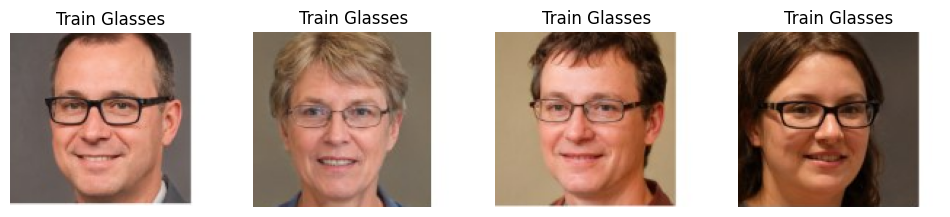

Train Glasses 총 이미지 수 : 52


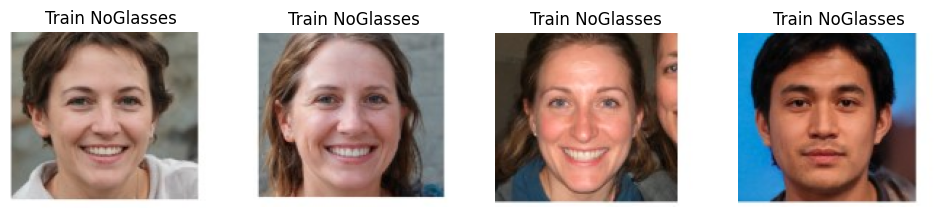

Train NoGlasses 총 이미지 수 : 52


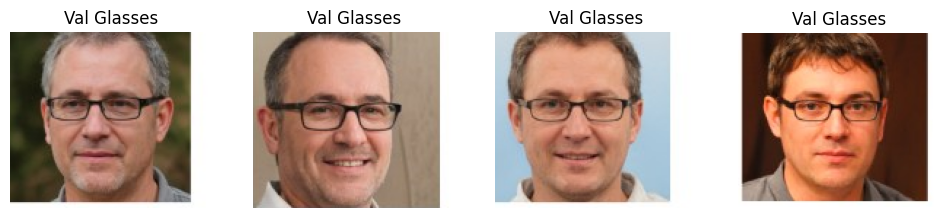

Val Glasses 총 이미지 수 : 20


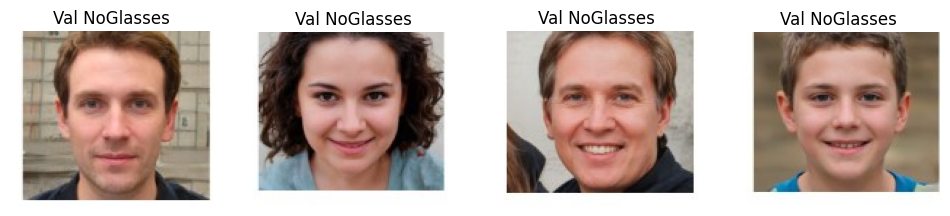

Val NoGlasses 총 이미지 수 : 20


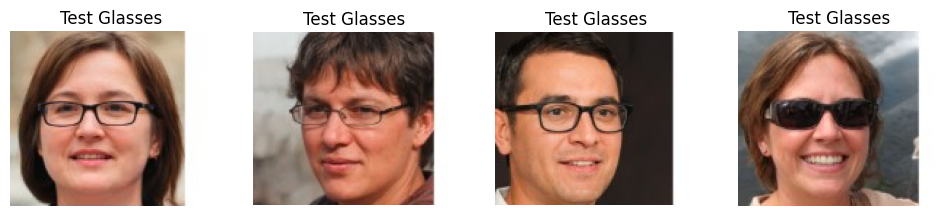

Test Glasses 총 이미지 수 : 10


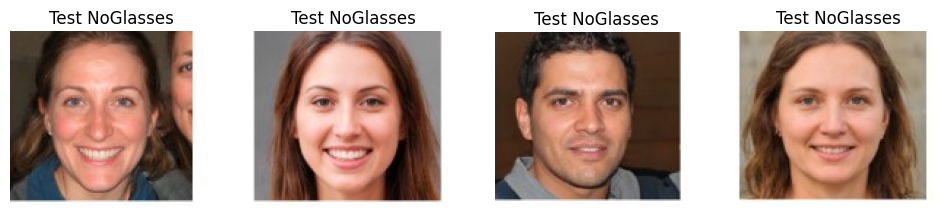

Test NoGlasses 총 이미지 수 : 10


In [6]:
for category in categories :
    image_paths = glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images_center_crop(image_paths, category)

    print(f'{category} 총 이미지 수 : {len(image_paths)}')

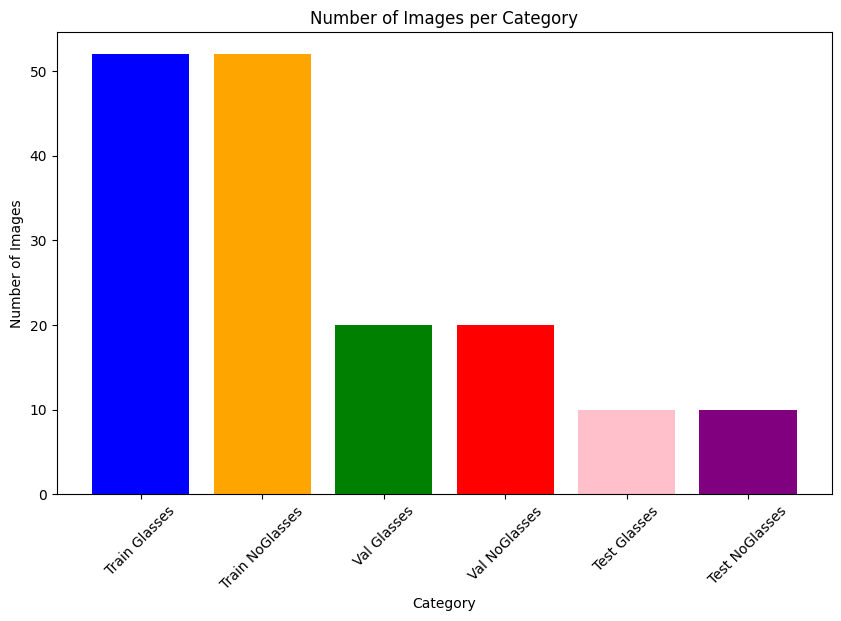

In [7]:
plt.figure(figsize = (10, 6))
plt.bar(categories, [len(glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*'))
    for category in categories], color = ['blue', 'orange', 'green', 'red', 'pink', 'purple'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation = 45)

plt.show()

In [8]:
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 이미지를 무작위로 수평 뒤집기
    transforms.RandomRotation(30),
    # 이미지의 밝기, 대비, 채도, 색조를 무작위로 변경
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
    transforms.RandomGrayscale(p = 0.2), # 20% 확률로 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_dataset = ImageFolder(f'{data_root}/train/', transform = transform)
val_dataset = ImageFolder(f'{data_root}/val/', transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 4, shuffle = False)

In [10]:
class AlexNet(nn.Module) :

    def __init__(self, num_classes = 1000) :
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size = 11, stride = 4, padding = 2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size = 5, padding = 2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size = 3, padding = 1)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout()

    def forward(self, x) :
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))

        # FC Layer

        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [11]:
model = AlexNet(num_classes = 2)
model = model.to(device)

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [13]:
def calculate_accuracy(loader, model) :
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad() :

        for data in loader :
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [14]:
train_losses = []
val_losses = []
val_accuracies = []

In [15]:
epochs = 30

for epoch in range(epochs) :
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader) :
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    model.eval()

    with torch.no_grad() :

        for inputs, labels in val_loader :
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = calculate_accuracy(val_loader, model)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss : {train_loss : .6f}, Val Loss : {val_loss : .6f}, Val Accuracy : {val_accuracy : .2f}%')

Epoch 1, Train Loss :  0.697771, Val Loss :  0.693246, Val Accuracy :  50.00%
Epoch 2, Train Loss :  0.694451, Val Loss :  0.692737, Val Accuracy :  50.00%
Epoch 3, Train Loss :  0.692394, Val Loss :  0.691091, Val Accuracy :  52.50%
Epoch 4, Train Loss :  0.620216, Val Loss :  0.944462, Val Accuracy :  57.50%
Epoch 5, Train Loss :  0.665932, Val Loss :  1.030558, Val Accuracy :  52.50%
Epoch 6, Train Loss :  0.529285, Val Loss :  0.870580, Val Accuracy :  52.50%
Epoch 7, Train Loss :  0.488834, Val Loss :  0.711134, Val Accuracy :  57.50%
Epoch 8, Train Loss :  0.394397, Val Loss :  1.150313, Val Accuracy :  60.00%
Epoch 9, Train Loss :  0.406514, Val Loss :  0.954008, Val Accuracy :  62.50%
Epoch 10, Train Loss :  0.300587, Val Loss :  0.975925, Val Accuracy :  67.50%
Epoch 11, Train Loss :  0.275529, Val Loss :  0.688937, Val Accuracy :  70.00%
Epoch 12, Train Loss :  0.338681, Val Loss :  2.108123, Val Accuracy :  52.50%
Epoch 13, Train Loss :  0.282297, Val Loss :  1.088831, Val A

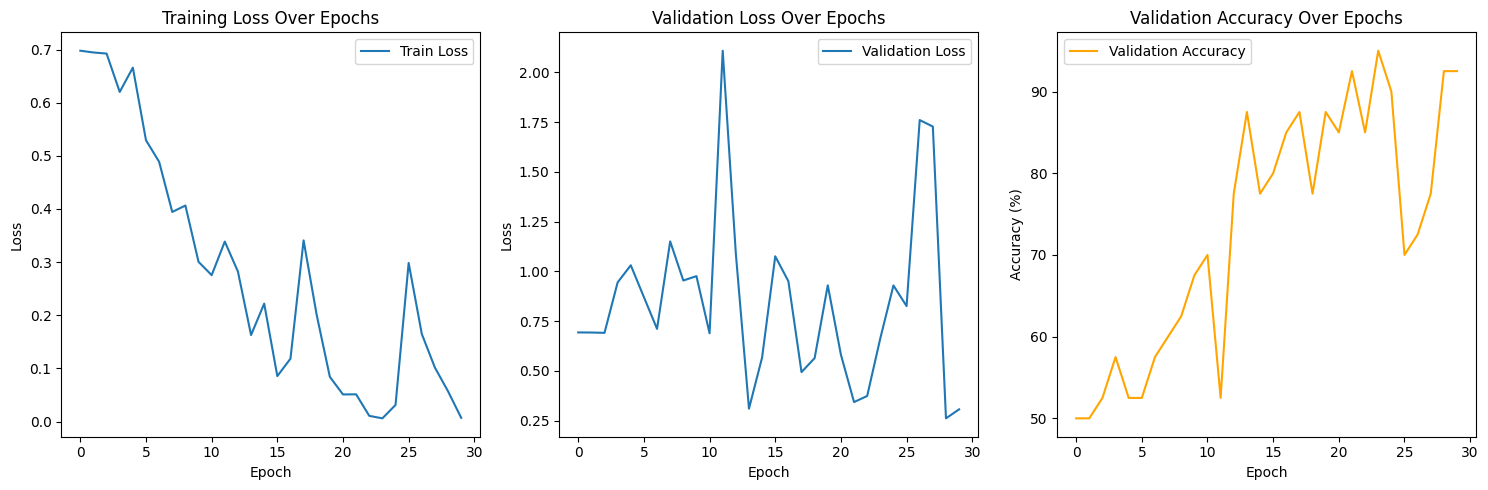

In [16]:
plt.figure(figsize=(15, 5))

# 학습 손실 그래프

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프

plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# test 데이터 에서 glass 5명, no glass 5명 에측이 정확한지 시각화

def load_and_transform_image(image_paths, transform) :
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    # 이미지 중앙의 정사각형 영역을 계산

    left = (width - 128) / 2
    top = (height - 128) / 2
    right = (width + 128) / 2
    bottom = (height + 128) / 2

    # 중앙 영역 크롭

    image_cropped = image.crop((left, top, right, bottom))

    return transform(image_cropped),image_cropped

In [34]:
class_folders = {
    'glass' : f'{data_root}/test/glasses',
    'no glass' : f'{data_root}/test/noglasses'
}

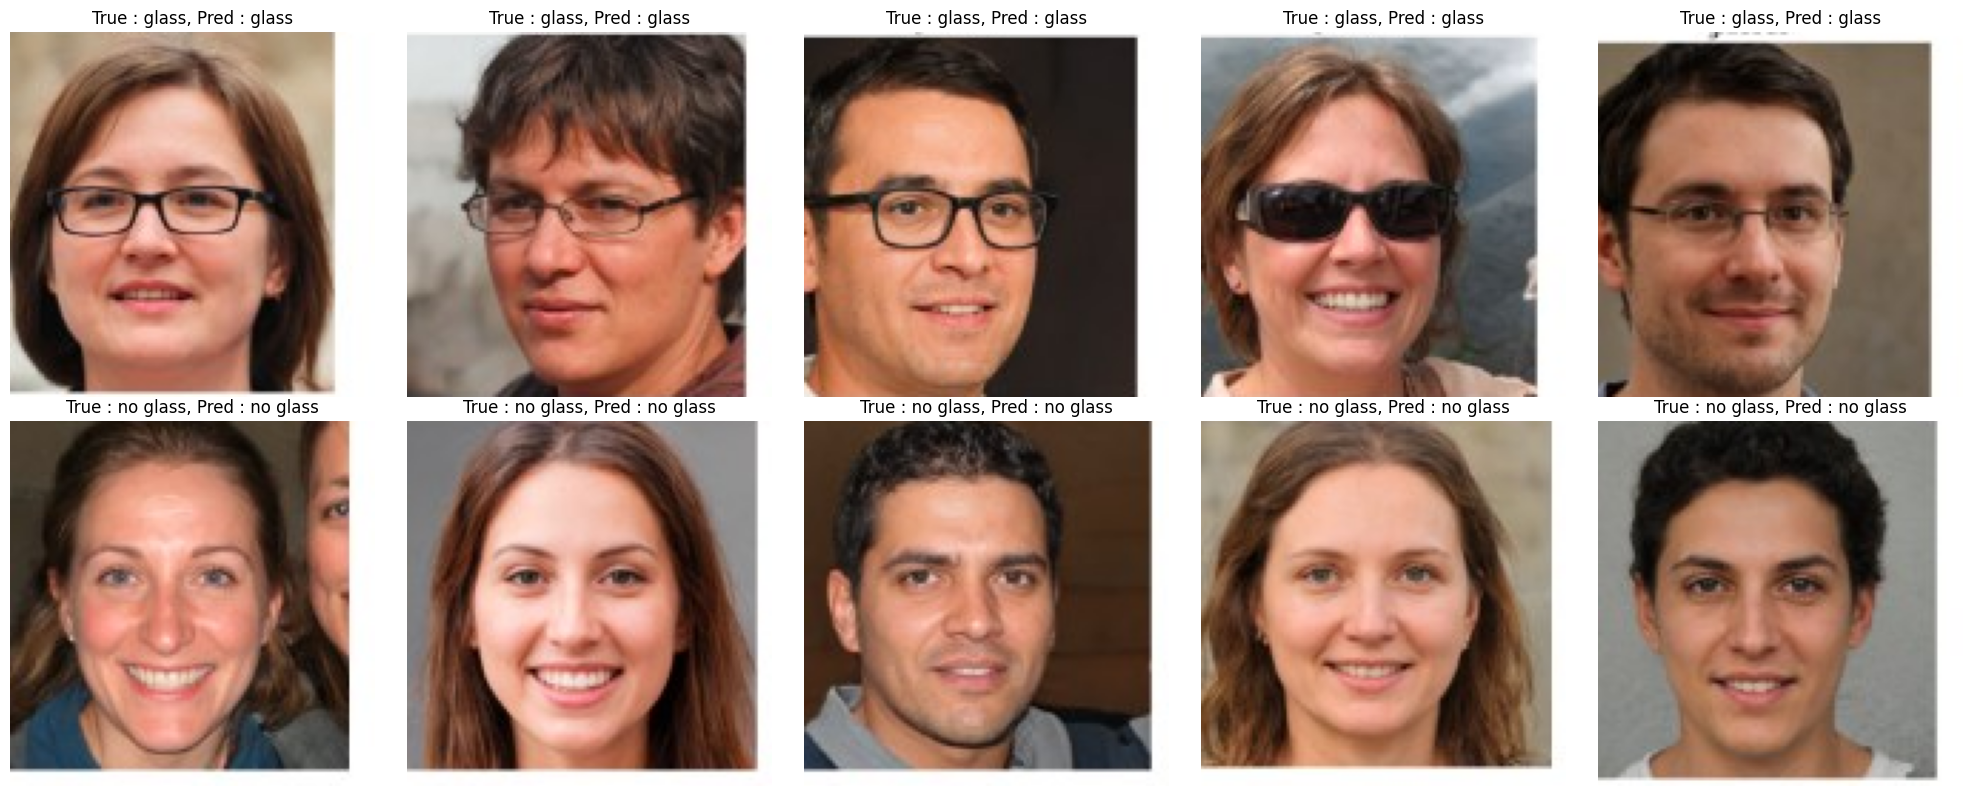

In [38]:
plt.figure(figsize = (20, 8))

counter = 1

for class_name, folder_path in class_folders.items() :
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[: 5]

    for image_path in selected_paths :
        image, image_cropped = load_and_transform_image(image_path, transform)
        image_unsqueeze = image.unsqueeze(0)
        image_unsqueeze = image_unsqueeze.to(device)

        outputs = model(image_unsqueeze)
        _, predicted = torch.max(outputs, 1)

        prediction = 'glass' if predicted.item() == 0 else 'no glass'

        plt.subplot(2, 5, counter)
        plt.imshow(image_cropped)
        plt.title(f'True : {class_name}, Pred : {prediction}')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()